In [1]:
import sounddevice as sd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import time

In [ ]:
time.strftime('%H %M %S')

class myObj:
    def __init__(self, name):
        self.name = name

    def __getattr__(self, attr):
        if attr == 'name':
            return self.name
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{attr}'")

example = myObj('example')

hasattr(example, 'name')

example.surname

AttributeError: 'myObj' object has no attribute 'surname'

In [12]:
def record_audio(duration=5, samplerate=16000):
    """Record audio from microphone at given samplerate"""
    print(f"Recording {duration}s at {samplerate}Hz...")
    audio = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
    sd.wait()
    return audio.flatten()

# Example usage:
sr=44100
audio = record_audio(duration=5, samplerate=sr)  

# store in data folder
sf.write('../data/dummy_audio_44100.wav', audio, sr)

Recording 5s at 44100Hz...


In [14]:
def record_audio(duration=5, sample_rate=22050):
    """Record audio from microphone"""
    print(f"Recording for {duration} seconds...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished
    print("Recording finished!")
    return audio.flatten(), sample_rate

def extract_mfcc(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=128):
    """
    Extract MFCCs following the 4-step process:
    1. Apply Fourier transform to short audio segments
    2. Map spectrum to Mel scale via triangular filter bank
    3. Take logarithm of filterbank energies
    4. Apply DCT to decorrelate and compress coefficients
    """
    # Step 1 & 2: FFT + Mel filter bank (done internally by melspectrogram)
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, 
        n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    
    # Step 3: Take logarithm (approximating human loudness perception)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Step 4: Apply DCT to decorrelate and compress
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr,
        n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    
    return mfcc, log_mel_spec

def plot_mfcc_comparison(mfcc, log_mel_spec, sr, hop_length=512):
    """Plot both MFCC and intermediate mel spectrogram"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot intermediate mel spectrogram (before DCT)
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length,
                           x_axis='time', y_axis='mel', ax=ax1)
    ax1.set_title('Step 3: Log Mel Spectrogram (before DCT)')
    ax1.set_ylabel('Mel Frequency')
    
    # Plot final MFCCs (after DCT)
    librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length,
                           x_axis='time', ax=ax2)
    ax2.set_title('Step 4: MFCCs (after DCT compression)')
    ax2.set_ylabel('MFCC Coefficient')
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [15]:
# Record audio (5 seconds)
audio, sr = record_audio(duration=5)

# Extract mel spectrogram
mfcc, log_mel_spec = extract_mfcc(audio, sr, n_mfcc=13)

Recording for 5 seconds...
Recording finished!


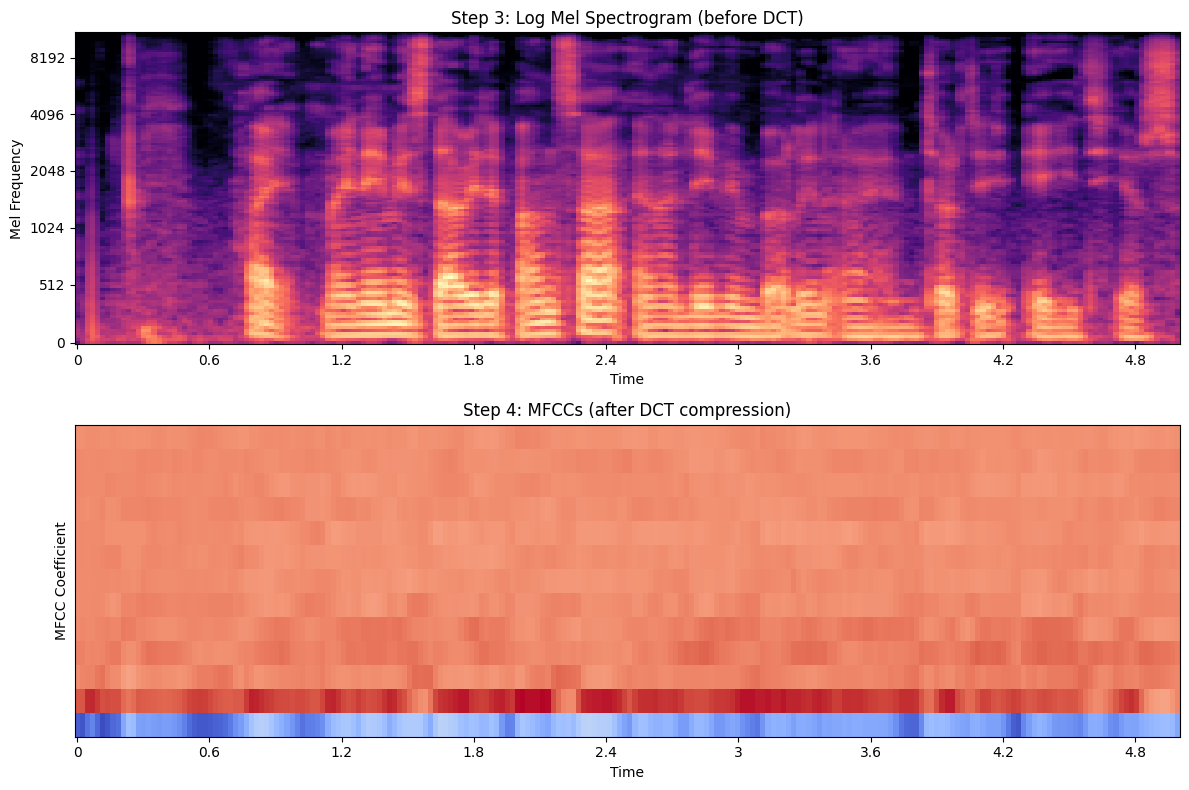

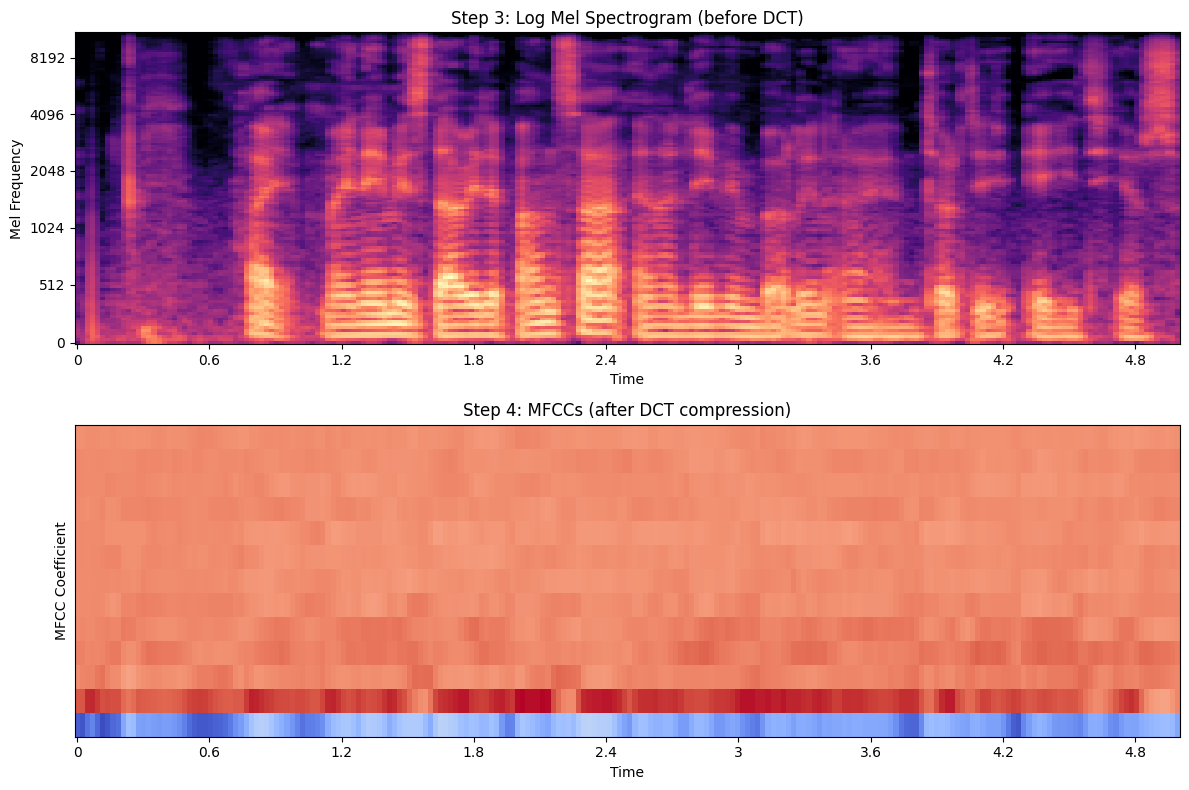

In [17]:
# Plot results
plot_mfcc_comparison(mfcc, log_mel_spec, sr)

## Extracting VAD - ONNX Version

In [ ]:
import os
import numpy as np
import librosa
import sounddevice as sd
import matplotlib.pyplot as plt
import requests
import zipfile
import audonnx
import audinterface

# Install required packages first:
# pip install audonnx audinterface

def download_official_model():
    """Download the official audEERING ONNX model"""
    import audeer
    
    model_root = 'model'
    cache_root = 'cache'
    
    os.makedirs(cache_root, exist_ok=True)
    
    def cache_path(file):
        return os.path.join(cache_root, file)
    
    url = 'https://zenodo.org/record/6221127/files/w2v2-L-robust-12.6bc4a7fd-1.1.0.zip'
    dst_path = cache_path('model.zip')
    
    if not os.path.exists(dst_path):
        print("Downloading official model...")
        audeer.download_url(url, dst_path, verbose=True)
    
    if not os.path.exists(model_root):
        print("Extracting model...")
        audeer.extract_archive(dst_path, model_root, verbose=True)
    
    return model_root

def load_official_model():
    """Load the official ONNX model"""
    
    model_root = download_official_model()
    model = audonnx.load(model_root)
    
    # Create interface for easier usage
    interface = audinterface.Feature(
        model.labels('logits'),
        process_func=model,
        process_func_args={'outputs': 'logits'},
        sampling_rate=16000,
        resample=True,
        verbose=False,
    )
    
    return model, interface

def predict_vad_official(audio, interface):
    """Predict VAD using official model"""
    # Process audio
    result = interface.process_signal(audio, 16000)
    
    # Extract values (result is a pandas DataFrame)
    arousal = float(result['arousal'].iloc[0])
    dominance = float(result['dominance'].iloc[0])
    valence = float(result['valence'].iloc[0])
    
    return {
        'arousal': arousal,
        'dominance': dominance,
        'valence': valence
    }

def extract_audio_envelope(audio, sr=16000, hop_length=512):
    """Extract amplitude envelope from audio"""
    rms_envelope = librosa.feature.rms(y=audio, hop_length=hop_length)[0]
    envelope_times = librosa.frames_to_time(np.arange(len(rms_envelope)), 
                                          sr=sr, hop_length=hop_length)
    return envelope_times, rms_envelope

def predict_vad_frames_with_envelope_official(audio, interface, window_size=1.0, hop_size=0.25):
    """Predict VAD frame-by-frame using official model + extract envelope"""
    sr = 16000
    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    
    vad_frames = []
    envelope_segments = []
    times = []
    
    # Extract full envelope
    full_envelope_times, full_envelope = extract_audio_envelope(audio, sr)
    
    # Sliding window for VAD
    for start in range(0, len(audio) - window_samples + 1, hop_samples):
        end = start + window_samples
        window_audio = audio[start:end]
        
        # Predict VAD for this window
        vad = predict_vad_official(window_audio, interface)
        vad_frames.append(vad)
        
        # Extract envelope for this segment
        seg_times, seg_envelope = extract_audio_envelope(window_audio, sr)
        envelope_segments.append({
            'times': seg_times + (start / sr),
            'envelope': seg_envelope,
            'mean_amplitude': np.mean(seg_envelope),
            'max_amplitude': np.max(seg_envelope),
            'amplitude_std': np.std(seg_envelope)
        })
        
        times.append(start / sr)
    
    # Convert to arrays
    arousal = [frame['arousal'] for frame in vad_frames]
    dominance = [frame['dominance'] for frame in vad_frames] 
    valence = [frame['valence'] for frame in vad_frames]
    
    return {
        'times': np.array(times),
        'arousal': np.array(arousal),
        'dominance': np.array(dominance),
        'valence': np.array(valence),
        'envelope_segments': envelope_segments,
        'full_envelope_times': full_envelope_times,
        'full_envelope': full_envelope,
        'window_size': window_size,
        'hop_size': hop_size
    }

def record_audio(duration=5):
    """Record audio from microphone"""
    print(f"Recording {duration}s...")
    audio = sd.rec(int(duration * 16000), samplerate=16000, channels=1, dtype='float32')
    sd.wait()
    return audio.flatten()

def test_official_model():
    """Test the official model with different emotions"""
    print("Loading official audEERING model...")
    model, interface = load_official_model()
    
    print("Testing with white noise (should give ~0.5-0.6 values):")
    np.random.seed(0)
    noise = np.random.normal(size=16000).astype(np.float32)
    noise_vad = predict_vad_official(noise, interface)
    print(f"Noise VAD: {noise_vad}")
    
    print("\nTest 1: Record something EXCITED/HAPPY")
    input("Press Enter when ready...")
    excited_audio = record_audio(3)
    excited_vad = predict_vad_official(excited_audio, interface)
    
    print("\nTest 2: Record something CALM/NEUTRAL")
    input("Press Enter when ready...")
    calm_audio = record_audio(3)
    calm_vad = predict_vad_official(calm_audio, interface)
    
    print("\nTest 3: Record something SAD/NEGATIVE")
    input("Press Enter when ready...")
    sad_audio = record_audio(3)
    sad_vad = predict_vad_official(sad_audio, interface)
    
    print(f"\nComparison (should show bigger differences now!):")
    print(f"Excited: A={excited_vad['arousal']:.3f}, D={excited_vad['dominance']:.3f}, V={excited_vad['valence']:.3f}")
    print(f"Calm:    A={calm_vad['arousal']:.3f}, D={calm_vad['dominance']:.3f}, V={calm_vad['valence']:.3f}")
    print(f"Sad:     A={sad_vad['arousal']:.3f}, D={sad_vad['dominance']:.3f}, V={sad_vad['valence']:.3f}")
    
    return interface

def analyze_voice_complete_official(duration=5, window_size=1.0, hop_size=0.25):
    """Complete voice analysis with official model"""
    print("Loading official model...")
    model, interface = load_official_model()
    
    print("Recording...")
    audio = record_audio(duration)
    
    print("Analyzing...")
    results = predict_vad_frames_with_envelope_official(audio, interface, window_size, hop_size)
    
    print(f"\nAnalysis Results:")
    print(f"Frames analyzed: {len(results['times'])}")
    print(f"VAD ranges:")
    print(f"  Arousal: {np.min(results['arousal']):.3f} to {np.max(results['arousal']):.3f}")
    print(f"  Dominance: {np.min(results['dominance']):.3f} to {np.max(results['dominance']):.3f}")
    print(f"  Valence: {np.min(results['valence']):.3f} to {np.max(results['valence']):.3f}")
    
    return results

# Usage - First test basic functionality:
#print("Step 1: Test basic model functionality")
# interface = test_official_model()


Step 1: Test basic model functionality
Loading official audEERING model...
Testing with white noise (should give ~0.5-0.6 values):
Noise VAD: {'arousal': 0.6563389301300049, 'dominance': 0.6307709217071533, 'valence': 0.47623327374458313}

Test 1: Record something EXCITED/HAPPY
Recording 3s...

Test 2: Record something CALM/NEUTRAL
Recording 3s...

Test 3: Record something SAD/NEGATIVE
Recording 3s...

Comparison (should show bigger differences now!):
Excited: A=0.231, D=0.309, V=0.419
Calm:    A=0.387, D=0.364, V=0.293
Sad:     A=0.586, D=0.574, V=0.628

Step 2: Full analysis


In [69]:
results = analyze_voice_complete_official(duration=10, window_size=0.025, hop_size=0.01)

Loading official model...
Recording...
Recording 10s...
Analyzing...

Analysis Results:
Frames analyzed: 998
VAD ranges:
  Arousal: 0.257 to 0.687
  Dominance: 0.273 to 0.655
  Valence: 0.310 to 0.646


In [59]:
results

{'times': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
        1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
        1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
        1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
        1.43, 1.44, 1.45, 1.4

## Experiment with Torus

## with pyTreeJS

In [1]:
import numpy as np
import pythreejs as p3
from IPython.display import display
import ipywidgets as widgets
from noise import pnoise2


In [67]:

class TorusVADMapper3D:
    def __init__(self, R=2, r=0.5, resolution=30):
        self.R = R
        self.r = r
        self.resolution = resolution
    
    def create_torus(self):
        """Create basic torus geometry"""
        u = np.linspace(0, 2*np.pi, self.resolution)
        v = np.linspace(0, 2*np.pi, self.resolution)
        u, v = np.meshgrid(u, v)
        
        x = (self.R + self.r * np.cos(v)) * np.cos(u)
        y = (self.R + self.r * np.cos(v)) * np.sin(u)
        z = self.r * np.sin(v)
        
        return x, y, z, u, v
    
    def map_dominance(self, x, y, z, u, dominance_values):
        """Map dominance to x-axis scaling at each timepoint"""
        x_mapped = x.copy()
        y_mapped = y.copy()
        z_mapped = z.copy()
        
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                angle_norm = u[i, j] / (2 * np.pi)
                dom_idx = int(angle_norm * (len(dominance_values) - 1))
                scale = 0.5 + dominance_values[dom_idx] * 1.5
                x_mapped[i, j] = x[i, j] * scale
        
        return x_mapped, y_mapped, z_mapped
    
    def map_arousal(self, x, y, z, u, v, arousal_values):
        """Map arousal to twist along Y-axis - rotate cross-sections based on Y position"""
        x_mapped = np.zeros_like(x)
        y_mapped = y.copy()  # Y unchanged (torus axis)
        z_mapped = np.zeros_like(z)
        
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                # Get timepoint from angle around torus
                angle_norm = u[i, j] / (2 * np.pi)
                ar_idx = int(angle_norm * (len(arousal_values) - 1))
                
                # Arousal creates twist: rotation angle proportional to Y position
                # Higher arousal = more twist
                twist_rate = (arousal_values[ar_idx] - 0.5) * 2.0  # -1 to +1
                y_pos = y[i, j]
                twist_angle = twist_rate * y_pos  # Twist proportional to Y
                
                # Apply twist rotation in X-Z plane
                cos_twist = np.cos(twist_angle)
                sin_twist = np.sin(twist_angle)
                
                x_orig = x[i, j]
                z_orig = z[i, j]
                
                x_mapped[i, j] = x_orig * cos_twist - z_orig * sin_twist
                z_mapped[i, j] = x_orig * sin_twist + z_orig * cos_twist
        
        return x_mapped, y_mapped, z_mapped
    
    def map_envelope(self, x, y, z, u, v, envelope_values):
        """Map envelope to minor radius (thickness) at each timepoint"""
        x_mapped = np.zeros_like(x)
        y_mapped = np.zeros_like(y)
        z_mapped = np.zeros_like(z)
        
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                angle_norm = u[i, j] / (2 * np.pi)
                env_idx = int(angle_norm * (len(envelope_values) - 1))
                r_dynamic = 0.2 + envelope_values[env_idx] * 0.8  # Vary thickness
                
                x_mapped[i, j] = (self.R + r_dynamic * np.cos(v[i, j])) * np.cos(u[i, j])
                y_mapped[i, j] = (self.R + r_dynamic * np.cos(v[i, j])) * np.sin(u[i, j])
                z_mapped[i, j] = r_dynamic * np.sin(v[i, j])
        
        return x_mapped, y_mapped, z_mapped
    
    def map_valence(self, x, y, z, u, v, valence_mean):
        """Map valence to surface noise displacement"""
        x_mapped = x.copy()
        y_mapped = y.copy()
        z_mapped = z.copy()
        
        noise_scale = valence_mean * 0.2
        
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                noise_val = pnoise2(u[i, j] * 2, v[i, j] * 2, octaves=3)
                displacement = noise_val * noise_scale
                
                # Calculate surface normal for displacement
                normal_x = np.cos(u[i, j]) * np.cos(v[i, j])
                normal_y = np.sin(u[i, j]) * np.cos(v[i, j])
                normal_z = np.sin(v[i, j])
                
                x_mapped[i, j] += normal_x * displacement
                y_mapped[i, j] += normal_y * displacement
                z_mapped[i, j] += normal_z * displacement
        
        return x_mapped, y_mapped, z_mapped
    
    def create_torus_geometry(self, x, y, z):
        """Convert numpy arrays to Three.js BufferGeometry with proper triangulation"""
        vertices = np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1).astype(np.float32)
        
        # Create indices for triangulation
        indices = []
        for i in range(self.resolution - 1):
            for j in range(self.resolution - 1):
                # Two triangles per quad
                v1 = i * self.resolution + j
                v2 = i * self.resolution + (j + 1)
                v3 = (i + 1) * self.resolution + j
                v4 = (i + 1) * self.resolution + (j + 1)
                
                indices.extend([v1, v2, v3, v2, v4, v3])
        
        geometry = p3.BufferGeometry(
            attributes={
                'position': p3.BufferAttribute(array=vertices),
                'index': p3.BufferAttribute(array=np.array(indices, dtype=np.uint32))
            }
        )
        
        return geometry
    
    def create_mesh(self, x, y, z, color='#ff6b35', wireframe=False):
        """Create Three.js mesh with surface visible"""
        geometry = self.create_torus_geometry(x, y, z)
        
        material = p3.MeshLambertMaterial(
            color=color,
            wireframe=wireframe,
            transparent=True,
            opacity=0.9
        )
        
        return p3.Mesh(geometry=geometry, material=material)
    
    def map_combined(self, dominance_values, arousal_values, envelope_values):
        """Apply all mappings combined (except valence) - FIXED VERSION"""
        x, y, z, u, v = self.create_torus()
        
        # Step 1: Apply envelope (changes the base torus shape)
        x_env, y_env, z_env = self.map_envelope(x, y, z, u, v, envelope_values)
        
        # Step 2: Apply dominance (scales in X)
        x_dom, y_dom, z_dom = self.map_dominance(x_env, y_env, z_env, u, dominance_values)
        
        # Step 3: Apply arousal (twist along Y-axis)
        x_final, y_final, z_final = self.map_arousal(x_dom, y_dom, z_dom, u, v, arousal_values)
        
        return x_final, y_final, z_final
    
    def create_single_scene(self, x, y, z, color, title):
        """Create a single Three.js scene with unique renderer"""
        mesh = self.create_mesh(x, y, z, color, wireframe=False)
        
        camera = p3.PerspectiveCamera(position=[8, 6, 8], fov=60)
        light = p3.DirectionalLight(color='white', position=[5, 5, 5])
        ambient = p3.AmbientLight(color='white', intensity=0.4)
        scene = p3.Scene(children=[mesh, light, ambient])
        controls = p3.OrbitControls(controlling=camera)
        
        renderer = p3.Renderer(
            camera=camera, 
            scene=scene, 
            controls=[controls], 
            width=600, 
            height=400
        )
        
        return renderer
    
    def visualize_interactive_navigator(self, dominance_values, arousal_values, valence_mean, envelope_values):
        """Create interactive navigator to view all 6 visualizations one at a time"""
        x, y, z, u, v = self.create_torus()
        
        # Pre-calculate all transformations
        dom_x, dom_y, dom_z = self.map_dominance(x.copy(), y.copy(), z.copy(), u, dominance_values)
        ar_x, ar_y, ar_z = self.map_arousal(x.copy(), y.copy(), z.copy(), u, v, arousal_values)
        env_x, env_y, env_z = self.map_envelope(x.copy(), y.copy(), z.copy(), u, v, envelope_values)
        val_x, val_y, val_z = self.map_valence(x.copy(), y.copy(), z.copy(), u, v, valence_mean)
        comb_x, comb_y, comb_z = self.map_combined(dominance_values, arousal_values, envelope_values)
        
        transformations = [
            {
                'x': x.copy(), 'y': y.copy(), 'z': z.copy(), 
                'color': '#4CAF50', 'title': 'Original Torus', 
                'description': "Perfect symmetric torus - baseline geometry"
            },
            {
                'x': dom_x, 'y': dom_y, 'z': dom_z,
                'color': '#F44336', 'title': 'Dominance → X Scale', 
                'description': "Dominance mapped to X-axis scaling - wider/narrower torus"
            },
            {
                'x': ar_x, 'y': ar_y, 'z': ar_z,
                'color': '#FF9800', 'title': 'Arousal → Y Twist', 
                'description': "Arousal creates helical twist along Y-axis"
            },
            {
                'x': env_x, 'y': env_y, 'z': env_z,
                'color': '#2196F3', 'title': 'Envelope → Thickness', 
                'description': "Envelope controls minor radius - thickness variation"
            },
            {
                'x': val_x, 'y': val_y, 'z': val_z,
                'color': '#9C27B0', 'title': 'Valence → Surface Noise', 
                'description': "Valence adds surface texture/noise displacement"
            },
            {
                'x': comb_x, 'y': comb_y, 'z': comb_z,
                'color': '#E91E63', 'title': 'All Combined', 
                'description': "Combined: envelope + dominance + arousal effects"
            }
        ]
        
        # Current scene index
        current_scene = [0]  # Use list to allow modification in nested function
        
        # Create initial scene
        current_renderer = self.create_single_scene(transformations[0]['x'], transformations[0]['y'], 
                                                   transformations[0]['z'], transformations[0]['color'], 
                                                   transformations[0]['title'])
        
        # Scene container
        scene_container = widgets.VBox([current_renderer])
        
        # Navigation buttons
        prev_btn = widgets.Button(description="◀ Previous", button_style='info', layout=widgets.Layout(width='120px'))
        next_btn = widgets.Button(description="Next ▶", button_style='info', layout=widgets.Layout(width='120px'))
        
        # Scene info
        scene_title = widgets.HTML(f"<h3 style='text-align:center;color:{transformations[0]['color']}'>{transformations[0]['title']}</h3>")
        scene_desc = widgets.HTML(f"<p style='text-align:center;font-style:italic'>{transformations[0]['description']}</p>")
        scene_counter = widgets.HTML(f"<p style='text-align:center'><strong>Scene 1 of {len(transformations)}</strong></p>")
        
        def update_scene(scene_idx):
            """Update the displayed scene"""
            trans = transformations[scene_idx]
            
            # Create new renderer with fresh scene
            new_renderer = self.create_single_scene(trans['x'], trans['y'], trans['z'], trans['color'], trans['title'])
            
            # Update container
            scene_container.children = [new_renderer]
            
            # Update info
            scene_title.value = f"<h3 style='text-align:center;color:{trans['color']}'>{trans['title']}</h3>"
            scene_desc.value = f"<p style='text-align:center;font-style:italic'>{trans['description']}</p>"
            scene_counter.value = f"<p style='text-align:center'><strong>Scene {scene_idx + 1} of {len(transformations)}</strong></p>"
            
            # Update button states
            prev_btn.disabled = (scene_idx == 0)
            next_btn.disabled = (scene_idx == len(transformations) - 1)
        
        def on_prev_click(b):
            if current_scene[0] > 0:
                current_scene[0] -= 1
                update_scene(current_scene[0])
        
        def on_next_click(b):
            if current_scene[0] < len(transformations) - 1:
                current_scene[0] += 1
                update_scene(current_scene[0])
        
        prev_btn.on_click(on_prev_click)
        next_btn.on_click(on_next_click)
        
        # Initialize button states
        prev_btn.disabled = True
        
        # Navigation bar
        nav_bar = widgets.HBox([prev_btn, next_btn], layout=widgets.Layout(justify_content='center'))
        
        # Main layout
        main_title = widgets.HTML("<h2 style='text-align:center;color:#ff6b35'>Torus VAD Mapping - Interactive Navigator</h2>")
        
        layout = widgets.VBox([
            main_title,
            scene_counter,
            scene_title,
            scene_desc,
            scene_container,
            nav_bar
        ])
        
        return layout
    
    def visualize_side_by_side_comparison(self, dominance_values, arousal_values, valence_mean, envelope_values):
        """Create side-by-side comparison of original vs combined"""
        x, y, z, u, v = self.create_torus()
        
        # Original torus
        original_scene = self.create_single_scene(x, y, z, '#4CAF50', 'Original')
        
        # Combined transformation
        x_comb, y_comb, z_comb = self.map_combined(dominance_values, arousal_values, envelope_values)
        combined_scene = self.create_single_scene(x_comb, y_comb, z_comb, '#E91E63', 'Combined')
        
        # Side by side layout
        comparison = widgets.HBox([
            widgets.VBox([
                widgets.HTML("<h4 style='text-align:center;color:#4CAF50'>Original Torus</h4>"),
                original_scene
            ]),
            widgets.VBox([
                widgets.HTML("<h4 style='text-align:center;color:#E91E63'>All Effects Combined</h4>"),
                combined_scene
            ])
        ])
        
        main_title = widgets.HTML("<h2 style='text-align:center;color:#ff6b35'>Original vs Combined Comparison</h2>")
        
        return widgets.VBox([main_title, comparison])
    
    def visualize_all_6_fixed(self, dominance_values, arousal_values, valence_mean, envelope_values):
        """Show all 6 visualizations simultaneously - FIXED VERSION"""
        x, y, z, u, v = self.create_torus()
        
        # Pre-calculate all transformations with FRESH data for each
        transformations = [
            {
                'x': x.copy(), 'y': y.copy(), 'z': z.copy(), 
                'color': '#4CAF50', 'title': 'Original Torus'
            },
            {
                'x': self.map_dominance(x.copy(), y.copy(), z.copy(), u, dominance_values)[0],
                'y': self.map_dominance(x.copy(), y.copy(), z.copy(), u, dominance_values)[1],
                'z': self.map_dominance(x.copy(), y.copy(), z.copy(), u, dominance_values)[2],
                'color': '#F44336', 'title': 'Dominance → X Scale'
            },
            {
                'x': self.map_arousal(x.copy(), y.copy(), z.copy(), u, v, arousal_values)[0],
                'y': self.map_arousal(x.copy(), y.copy(), z.copy(), u, v, arousal_values)[1],
                'z': self.map_arousal(x.copy(), y.copy(), z.copy(), u, v, arousal_values)[2],
                'color': '#FF9800', 'title': 'Arousal → Y Twist'
            },
            {
                'x': self.map_envelope(x.copy(), y.copy(), z.copy(), u, v, envelope_values)[0],
                'y': self.map_envelope(x.copy(), y.copy(), z.copy(), u, v, envelope_values)[1],
                'z': self.map_envelope(x.copy(), y.copy(), z.copy(), u, v, envelope_values)[2],
                'color': '#2196F3', 'title': 'Envelope → Thickness'
            },
            {
                'x': self.map_valence(x.copy(), y.copy(), z.copy(), u, v, valence_mean)[0],
                'y': self.map_valence(x.copy(), y.copy(), z.copy(), u, v, valence_mean)[1],
                'z': self.map_valence(x.copy(), y.copy(), z.copy(), u, v, valence_mean)[2],
                'color': '#9C27B0', 'title': 'Valence → Surface Noise'
            },
            {
                'x': self.map_combined(dominance_values, arousal_values, envelope_values)[0],
                'y': self.map_combined(dominance_values, arousal_values, envelope_values)[1],
                'z': self.map_combined(dominance_values, arousal_values, envelope_values)[2],
                'color': '#E91E63', 'title': 'All Combined'
            }
        ]
        
        # Create smaller renderers for grid layout
        renderers = []
        for i, trans in enumerate(transformations):
            # Create mesh with unique geometry for each scene
            mesh = self.create_mesh(trans['x'], trans['y'], trans['z'], trans['color'], wireframe=False)
            
            # Create unique camera and scene for each renderer
            camera = p3.PerspectiveCamera(position=[6, 4, 6], fov=50)  # Smaller view for grid
            light = p3.DirectionalLight(color='white', position=[3, 3, 3])
            ambient = p3.AmbientLight(color='white', intensity=0.4)
            scene = p3.Scene(children=[mesh, light, ambient])
            controls = p3.OrbitControls(controlling=camera)
            
            # Create renderer with unique key to prevent conflicts
            renderer = p3.Renderer(
                camera=camera, 
                scene=scene, 
                controls=[controls], 
                width=300,  # Smaller for grid
                height=250,
                alpha=True,
                antialias=True
            )
            
            # Force unique renderer ID to prevent conflicts
            renderer._model_id = f"torus_renderer_{i}_{hash(trans['title']) % 10000}"
            
            renderers.append((renderer, trans['title'], trans['color']))
        
        # Create 2x3 grid layout with titles
        def create_titled_scene(renderer, title, color):
            title_widget = widgets.HTML(
                f"<h4 style='text-align:center;color:{color};margin:5px;font-size:14px'>{title}</h4>"
            )
            return widgets.VBox([title_widget, renderer], layout=widgets.Layout(margin='5px'))
        
        # Create grid rows
        row1 = widgets.HBox([
            create_titled_scene(renderers[0][0], renderers[0][1], renderers[0][2]),
            create_titled_scene(renderers[1][0], renderers[1][1], renderers[1][2]),
            create_titled_scene(renderers[2][0], renderers[2][1], renderers[2][2])
        ], layout=widgets.Layout(justify_content='space-around'))
        
        row2 = widgets.HBox([
            create_titled_scene(renderers[3][0], renderers[3][1], renderers[3][2]),
            create_titled_scene(renderers[4][0], renderers[4][1], renderers[4][2]),
            create_titled_scene(renderers[5][0], renderers[5][1], renderers[5][2])
        ], layout=widgets.Layout(justify_content='space-around'))
        
        # Main layout
        main_title = widgets.HTML("<h2 style='text-align:center;color:#ff6b35;margin:15px'>Torus VAD Mapping - All 6 Views (FIXED)</h2>")
        
        description = widgets.HTML("""
        <div style='text-align:center;margin:10px;color:#666'>
        <p><strong>Each visualization shows a different VAD component effect:</strong></p>
        <p>🟢 Original | 🔴 Dominance (X-scale) | 🟠 Arousal (Y-twist) | 🔵 Envelope (thickness) | 🟣 Valence (noise) | 🔴 Combined</p>
        </div>
        """)
        
        layout = widgets.VBox([
            main_title,
            description,
            row1,
            row2
        ], layout=widgets.Layout(padding='10px'))
        
        return layout

def test_all_6_grid(dominance_values, arousal_values, valence_mean, envelope_values):
    """Test side-by-side comparison"""
    if dominance_values is None: dominance_values = np.array([0.1, 0.3, 0.9, 0.7, 0.2, 0.8, 0.4, 0.6])
    if arousal_values is None: arousal_values = np.array([0.0, 0.2, 1.0, 0.8, 0.1, 0.9, 0.3, 0.5])    
    if valence_mean is None: valence_mean = 0.7
    if envelope_values is None: envelope_values = np.array([0.0, 0.4, 1.0, 0.6, 0.2, 0.8, 0.1, 0.7])
    
    print("Creating all 6 torus visualizations in grid layout (FIXED)...")
    print(f"Dominance range: {dominance_values.min():.1f} - {dominance_values.max():.1f}")
    print(f"Arousal range: {arousal_values.min():.1f} - {arousal_values.max():.1f}")
    print(f"Envelope range: {envelope_values.min():.1f} - {envelope_values.max():.1f}")
    print(f"Valence: {valence_mean:.1f}")
    
    mapper = TorusVADMapper3D(resolution=200)
    layout = mapper.visualize_all_6_fixed(dominance_values, arousal_values, valence_mean, envelope_values)
    
    print("\nWhat to look for in the 2x3 grid:")
    print("Top row:")
    print("  - Left: Original torus (perfect symmetric)")
    print("  - Middle: Dominance effect (X-axis scaling)")  
    print("  - Right: Arousal effect (Y-axis helical twist)")
    print("Bottom row:")
    print("  - Left: Envelope effect (thickness variations)")
    print("  - Middle: Valence effect (surface noise/bumps)")
    print("  - Right: Combined effects (envelope + dominance + arousal)")
    print("\nEach visualization should be independently interactive!")
    print("The arousal visualization should show clear twisted/spiral pattern.")
    
    display(layout)
    return layout

def test_side_by_side(dominance_values, arousal_values, valence_mean, envelope_values):
    """Test side-by-side comparison"""
    if dominance_values is None: dominance_values = np.array([0.1, 0.3, 0.9, 0.7, 0.2, 0.8, 0.4, 0.6])
    if arousal_values is None: arousal_values = np.array([0.0, 0.2, 1.0, 0.8, 0.1, 0.9, 0.3, 0.5])    
    if valence_mean is None: valence_mean = 0.7
    if envelope_values is None: envelope_values = np.array([0.0, 0.4, 1.0, 0.6, 0.2, 0.8, 0.1, 0.7])
    
    mapper = TorusVADMapper3D(resolution=25)
    layout = mapper.visualize_side_by_side_comparison(dominance_values, arousal_values, valence_mean, envelope_values)
    
    print("Side-by-side comparison: Original vs All Effects Combined")
    display(layout)
    return layout



In [70]:
# Run the interactive navigator
print("=== INTERACTIVE NAVIGATOR ===")
nav_layout = test_all_6_grid(dominance_values=results['dominance'],
                                        arousal_values=results['arousal'],
                                        valence_mean=np.mean(results['valence']),
                                        envelope_values=results['full_envelope']*30)

# print("\n=== SIDE-BY-SIDE COMPARISON ===")
# compare_layout = test_side_by_side()

=== INTERACTIVE NAVIGATOR ===
Creating all 6 torus visualizations in grid layout (FIXED)...
Dominance range: 0.3 - 0.7
Arousal range: 0.3 - 0.7
Envelope range: 0.0 - 0.6
Valence: 0.4

What to look for in the 2x3 grid:
Top row:
  - Left: Original torus (perfect symmetric)
  - Middle: Dominance effect (X-axis scaling)
  - Right: Arousal effect (Y-axis helical twist)
Bottom row:
  - Left: Envelope effect (thickness variations)
  - Middle: Valence effect (surface noise/bumps)
  - Right: Combined effects (envelope + dominance + arousal)

Each visualization should be independently interactive!
The arousal visualization should show clear twisted/spiral pattern.


[{'times': array([0.   , 0.032, 0.064, 0.096, 0.128, 0.16 , 0.192, 0.224]),
  'envelope': array([4.9574162e-05, 6.7082939e-05, 8.3936713e-05, 9.2150673e-05,
         1.1676126e-04, 1.7765629e-04, 2.8163777e-04, 2.7698229e-04],
        dtype=float32),
  'mean_amplitude': 0.00014322277,
  'max_amplitude': 0.00028163777,
  'amplitude_std': 8.633274e-05},
 {'times': array([0.1  , 0.132, 0.164, 0.196, 0.228, 0.26 , 0.292, 0.324]),
  'envelope': array([6.98260264e-05, 1.11641304e-04, 1.83133045e-04, 3.15849436e-04,
         4.41829179e-04, 4.92821040e-04, 5.09741250e-04, 4.37753130e-04],
        dtype=float32),
  'mean_amplitude': 0.0003203243,
  'max_amplitude': 0.00050974125,
  'amplitude_std': 0.00016557715},
 {'times': array([0.2  , 0.232, 0.264, 0.296, 0.328, 0.36 , 0.392, 0.424]),
  'envelope': array([0.00032212, 0.00044985, 0.00049787, 0.00050627, 0.00046102,
         0.00036464, 0.00032347, 0.00025925], dtype=float32),
  'mean_amplitude': 0.0003980624,
  'max_amplitude': 0.0005062748